In [75]:
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt

def make_path(p):
    dirs = p.split('/')
    tmp = ''
    for i in range(len(dirs)):
        tmp = tmp+dirs[i]+'/'
        if not(os.path.exists(tmp)):
            os.mkdir(tmp)    

def save_tie(t_im,t_mask,prefix,max_length):
    assert(len(t_im) == max_length)
    if(max_length == 0):
        return ;
    cols = int(np.sqrt(len(t_im)))
    rows = int(np.ceil(len(t_im)/float(cols)))
    
    w = t_im.shape[2]
    h = t_im.shape[1]
    res_im = np.zeros((rows*h,cols*w,3),dtype=np.uint8)
    res_mask = np.zeros((rows*h,cols*w),dtype=np.uint8)
    for c in range(cols):
        for r in range(rows):
            if(r*cols+c < len(t_im)):
                res_im[r*h:r*h+h,c*w:c*w+w,:] = t_im[r*cols+c,:]
                res_mask[r*h:r*h+h,c*w:c*w+w] = t_mask[r*cols+c]
    cv2.imwrite(prefix+'_input.jpg',res_im)
    cv2.imwrite(prefix+'_mask.jpg',res_mask)
    
def iterate_video(d):
    d = d[(d.r1<0.9)&(d.r2<0.9)]
    if(len(d) > 0):
        im_shape = cv2.imread(d.x.values[0]).shape
    for i in range(len(d)):
        yield cv2.imread(d.x.values[i]), cv2.imread(d.y.values[i],0)
    
def iterate_img(img,mask,t_size):
    for i in range(img.shape[0]//t_size):
        for j in range(img.shape[1]//t_size):
            lo = (i*t_size),(j*t_size)
            hi = (i+1)*t_size if (i+2)*t_size < img.shape[0] else None,\
                 (j+1)*t_size if (j+2)*t_size < img.shape[1] else None
            tie_mask = mask[lo[0]:hi[0],lo[1]:hi[1]]
            tie_img  = img[lo[0]:hi[0],lo[1]:hi[1]]
            yield tie_img,tie_mask
        
def process_tie(ties,tie_mask):
        r0 = np.zeros_like(tie_mask,dtype=np.float32)
        r1 = np.zeros_like(tie_mask,dtype=np.float32)
        r3 = np.zeros_like(tie_mask,dtype=np.float32)
        r0[tie_mask < 10] = 1.
        r1[(tie_mask > 10)&(tie_mask < 240)] = 1.
        r3[tie_mask > 240] = 1.
        if(r1.mean() > 0.7):
            return False
        if(r3.mean() > 0.001):
            return True
        return False
    
def create_dataset(path = 'dataset/data.csv',out_dir='ties256',t_size=64,max_length=256):
    data = pd.read_csv(path)
    for video_num,d in enumerate(data.groupby('id')):
        if(video_num < 6):
            continue
        ties = []
        motion = []
        count = 0
        video_path = (out_dir+'/'+d[1].x.values[0])[:(out_dir+'/'+d[1].x.values[0]).rfind('/input')]
        make_path(video_path)
        for frame_num,(img,mask) in enumerate(iterate_video(d[1])):
            for i,(tie_img,tie_mask) in enumerate(iterate_img(img,mask,t_size)):
                if(len(ties)<=i):
                    ties.append([[tie_img],[tie_mask]])
                    motion.append([])
                else:
                    ties[i][0].append(tie_img)
                    ties[i][1].append(tie_mask)
                if(tie_mask[tie_mask > 240.].sum() > 0.94*255.*tie_mask.size):
                    motion[i].append(tie_img[:t_size,:t_size,:])
                if(len(ties[i][0]) >= max_length):
                    tie_img = np.array(ties[i][0],dtype=np.uint8)
                    tie_mask = np.array(ties[i][1],dtype=np.uint8)
                    if(process_tie(tie_img,tie_mask)):            
                        save_tie(tie_img,tie_mask,video_path+'/'+str(count),max_length=max_length)
                        count = count+1
                    ties[i] = [[],[]]
            print "\rvideo: %i frame: %i proper_ties: %i"%(video_num,frame_num,count),
        print ""
        all_motion = []
        for m in motion:
            all_motion=all_motion+m
        all_motion = np.array(all_motion)
        save_tie(all_motion,np.zeros(all_motion.shape[:-1])+255.,video_path+'/motion',max_length=len(all_motion))
        
create_dataset(out_dir='ties256',t_size=48,max_length=256)

video: 6 frame: 799 proper_ties: 62                                                                
video: 7 frame: 900 proper_ties: 217                                                                                                                         
video: 8 frame: 350 proper_ties: 64                               
video: 9 frame: 1710 proper_ties: 102                                                                                                                                                      
video: 10 frame: 400 proper_ties: 10                        
video: 11 frame: 670 proper_ties: 48                                    
video: 12 frame: 6099 proper_ties: 49                                                                                                                                                                                                                                                                                                                            

In [10]:
gmm_loader = GMMDataLoader(TieLoader('/media/data/Programming/motion_segmentation/gmm_segmentation/ties256',
                                    cols=16,rows=16,t_size=48),\
                           [32,32],[32,32],128,min_r=0.4,max_r=0.5)

/media/data/Programming/motion_segmentation/gmm_segmentation/ties256/dataset/badWeather/skating/motion_input.jpg
(128, 3, 32, 32)


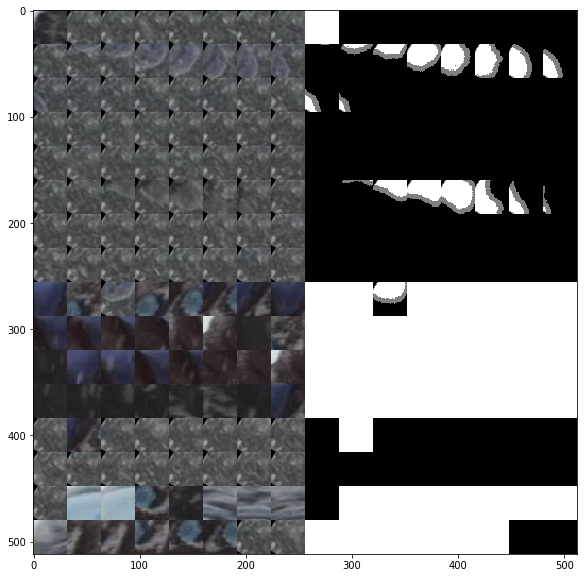

In [11]:
def data_generator(gmm_loader,batch_size = 1,
                   tile_size = 32,
                   epoch_size = 1):
    iter = 0
    for i in range(epoch_size):        
        yield gmm_loader.load_random()
        
for x,y in data_generator(gmm_loader,1,epoch_size=1):
    print x.shape
    draw_sample(x,y,8,128//8)
    break

In [12]:
import os
from test_tools import make_path
from shutil import move
import numpy as np

def train_test_split(data_dir = 'train/dataset',out_dir = 'test/dataset',test_size = 40):
    for i in os.listdir(data_dir):
        for j in os.listdir(data_dir+'/'+i)[:1]:
            p = '/'+i+'/'+j
            make_path(out_dir+'/'+i)
            move(data_dir+p,out_dir+'/'+i)
            break
    
    for i in os.listdir(out_dir):
        for j in os.listdir(out_dir+'/'+i):
            p = out_dir+'/'+i+'/'+j+osl.listdir(out_dir+'/'+i+'/'+j)[0]
            files = [p+'/'+k[:k.find('_')] for k in os.listdir(p) if k.find('mask') >= 0]
            np.random.shuffle(files)
            for k in files[test_size:]:
                os.remove(k+'_mask.jpg')
                os.remove(k+'_input.jpg')
            files = [p+'/'+k for k in os.listdir(p) if k.find('motion') >= 0]
            for k in files:
                os.remove(k)

In [22]:
data_dir = 'train/dataset'
out_dir = 'test/dataset'
test_size = 50
for i in os.listdir(out_dir):
    for j in os.listdir(out_dir+'/'+i):
        p = out_dir+'/'+i+'/'+j
        files = [p+'/'+k[:k.find('_')] for k in os.listdir(p) if k.find('mask') >= 0]
        np.random.shuffle(files)
        for k in files[test_size:]:
            os.remove(k+'_mask.jpg')
            os.remove(k+'_input.jpg')
        files = [p+'/'+k for k in os.listdir(p) if k.find('motion') >= 0]
        for k in files:
            os.remove(k)